In [11]:
# Standard data science libraries
import numpy as np 
import pandas as pd 

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, BaggingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from category_encoders import TargetEncoder

# System and warnings management
import os
import warnings
warnings.filterwarnings('ignore')

# Display available files in the input directory
print("Files in the input directory:")
for dirname, _, filenames in os.walk('archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Files in the input directory:
archive/luxury_cosmetics_fraud_analysis_2025.xlsx
archive/luxury_cosmetics_fraud_analysis_2025.json
archive/luxury_cosmetics_fraud_analysis_2025.csv


In [12]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('archive/luxury_cosmetics_fraud_analysis_2025.csv')

## 2. Initial Data Exploration
A crucial first step is to understand the structure and content of our dataset. This involves inspecting the first few rows, checking data types, and identifying any initial data quality issues. We also examine the distribution of key categorical features to inform subsequent feature engineering decisions.

In [13]:
# Display the first 5 rows of the DataFrame to get an overview
df.head()

,Transaction_ID,Customer_ID,Transaction_Date,Transaction_Time,Customer_Age,Customer_Loyalty_Tier,Location,Store_ID,Product_SKU,Product_Category,Purchase_Amount,Payment_Method,Device_Type,IP_Address,Fraud_Flag,Footfall_Count
0,702bdd9b-9c93-41e3-9dbb-a849b2422080,119dca0b-8554-4b2d-9bec-e964eaf6af97,2025-07-27,04:04:15,56.0,Silver,San Francisco,FLAGSHIP-LA,NEBULA-SERUM-07,Concealer,158.24,Mobile Payment,Desktop,239.249.58.237,0,333
1,2e64c346-36bc-4acf-bc2b-8b0fdf46abc5,299df086-26c4-4708-b6d7-fcaeceb14637,2025-03-14,20:23:23,46.0,Platinum,Zurich,BOUTIQUE-SHANGHAI,STELLAR-FOUND-03,Lipstick,86.03,Credit Card,Tablet,84.49.227.90,0,406
2,29ad1278-70ce-421f-8d81-23816b39f4ac,dfa3d24d-b935-49a5-aa1d-7d57a44d8773,2025-02-20,12:36:02,32.0,Silver,Milan,POPUP-TOKYO,SOLAR-BLUSH-04,Mascara,255.69,Gift Card,Desktop,79.207.35.55,0,96
3,07dc4894-e0eb-48f1-99a7-1942b1973d9b,7a67e184-9369-49ee-aeac-18f5b51b230f,2025-04-25,19:09:43,60.0,Bronze,London,BOUTIQUE-NYC,GALAXIA-SET-08,Serum,282.76,Gift Card,Mobile,176.194.167.253,0,186
4,ae407054-5543-429c-918a-cdcc42ea9782,cf14730a-8f5a-453d-b527-39a278852b27,2025-04-17,14:23:23,NaN,Platinum,Miami,BOUTIQUE-NYC,LUNAR-MASC-02,Serum,205.86,Gift Card,Mobile,166.31.46.111,0,179


In [14]:
# Check data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133 entries, 0 to 2132
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Transaction_ID         2133 non-null   object 
 1   Customer_ID            2133 non-null   object 
 2   Transaction_Date       2133 non-null   object 
 3   Transaction_Time       2133 non-null   object 
 4   Customer_Age           2027 non-null   float64
 5   Customer_Loyalty_Tier  2027 non-null   object 
 6   Location               2133 non-null   object 
 7   Store_ID               2133 non-null   object 
 8   Product_SKU            2133 non-null   object 
 9   Product_Category       2133 non-null   object 
 10  Purchase_Amount        2133 non-null   float64
 11  Payment_Method         2027 non-null   object 
 12  Device_Type            2133 non-null   object 
 13  IP_Address             2133 non-null   object 
 14  Fraud_Flag             2133 non-null   int64  
 15  Foot

Exploring the value counts for several categorical features provides insight into their distribution and potential for creating new, more informative features.

In [15]:
# Examine the distribution of Customer Loyalty Tiers
df['Customer_Loyalty_Tier'].value_counts()

Customer_Loyalty_Tier
Bronze      808
Silver      506
Gold        423
Platinum    179
VIP         111
Name: count, dtype: int64

In [16]:
# Investigate the distribution of transaction locations
df['Location'].value_counts()

Location
Sydney           128
Zurich           121
Shanghai         117
Cannes           114
Hong Kong        114
Monte Carlo      112
Singapore        112
San Francisco    109
London           108
Rome             107
Los Angeles      105
Miami            105
Dubai            103
Milan            103
Las Vegas        102
Geneva           100
Paris             97
Tokyo             95
New York          93
Monaco            88
Name: count, dtype: int64

In [17]:
# Check the distribution of Product Categories
df['Product_Category'].value_counts()

Product_Category
Serum                233
Highlighter          228
Blush                222
Mascara              219
Setting Spray        213
Lipstick             209
Eyeshadow Palette    209
Eyeliner             207
Concealer            199
Foundation           194
Name: count, dtype: int64

In [18]:
# Analyze the distribution of Payment Methods
df['Payment_Method'].value_counts()

Payment_Method
Debit Card        522
Gift Card         514
Mobile Payment    500
Credit Card       491
Name: count, dtype: int64

## 3. Feature Engineering
To enhance the predictive power of our models, we will create new features from existing ones and transform certain columns into a more suitable format. This stage involves:

- Dropping Redundant Identifiers: Removing Transaction_ID and Customer_ID as they are unique identifiers with no predictive value.
- Temporal Features: Extracting year, month, day, and hour from transaction timestamps.
- Loyalty Tier Transformation: Creating a binary indicator for VIP customers.
- Location Frequency: Identifying frequently occurring transaction locations.
- Store and Product SKU Decomposition: Breaking down Store_ID and Product_SKU into more granular components.
- Purchase Amount Binning: Flagging high-value purchases.
- Payment Method Categorization: Identifying card-based payments.
- IP Address Segmentation: Splitting IP addresses into their octets.

After generating these new features, the original columns from which they were derived, if no longer needed, will be dropped.

In [19]:
# Drop unique identifier columns that are not useful for modeling
df.drop(columns=['Transaction_ID', 'Customer_ID'], inplace=True)

In [20]:
# Convert 'Transaction_Date' and 'Transaction_Time' to datetime objects
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])
df['Transaction_Time'] = pd.to_datetime(df['Transaction_Time'], format='%H:%M:%S')

# Extract temporal features: Year, Month, Day, Hour
df['Year'] = df['Transaction_Date'].dt.year
df['Month'] = df['Transaction_Date'].dt.month
df['Day'] = df['Transaction_Date'].dt.day
df['Hour'] = df['Transaction_Time'].dt.hour

# Drop the original date and time columns
df.drop(columns=['Transaction_Date', 'Transaction_Time'], inplace=True)

In [21]:
# Create a binary flag for VIP loyalty tier customers
df['is_vip'] = df['Customer_Loyalty_Tier'].apply(lambda x: 'yes' if x=='VIP' else 'no')

In [22]:
# Identify locations with more than 100 transactions as 'frequent'
location_counts = df['Location'].value_counts()
df['is_frequent_locality'] = df['Location'].apply(lambda x : 'yes' if location_counts[x]>100 else 'no')

In [23]:
# Extract category and city information from 'Store_ID'
df['category_store_id'] = df['Store_ID'].apply(lambda x: x.lower().split('-')[0])
df['city_store_id'] = df['Store_ID'].apply(lambda x: x.lower().split('-')[1])

In [25]:
# Split 'Product_SKU' into Brand, Category, and Variant components
df[['Brand', 'Category', 'Variant']] = df['Product_SKU'].str.split('-', expand=True)

In [26]:
# Drop original 'Store_ID' and 'Product_SKU' columns as their components have been extracted
df.drop(columns=['Store_ID', 'Product_SKU'], inplace=True)

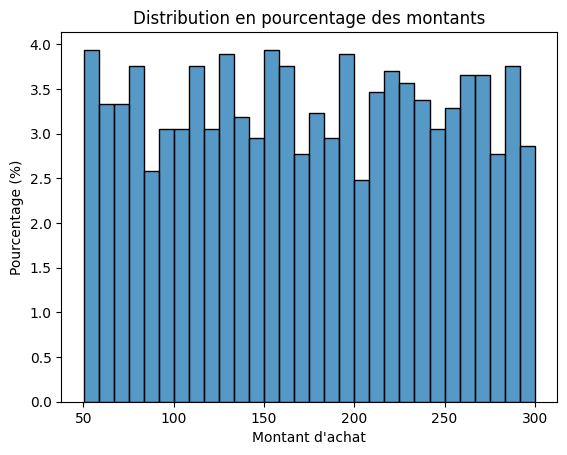

In [42]:
# Create a binary flag for purchases with an amount greater than 200
import seaborn as sns

import seaborn as sns
import matplotlib.pyplot as plt

# Histogramme en pourcentage
sns.histplot(df['Purchase_Amount'], bins=30, stat="percent", kde=False)

plt.title("Distribution en pourcentage des montants")
plt.xlabel("Montant d'achat")
plt.ylabel("Pourcentage (%)")
plt.show()

df['is_high_cost'] = df['Purchase_Amount'].apply(lambda x: x>200)

In [ ]:
# Create a binary flag for payments made using a 'Card'
df['is_card'] = df['Payment_Method'].apply(lambda x: str(x).strip().split(' ')[-1]=='Card')

In [43]:
# Split 'IP_Address' into its four octets
df[['IP1','IP2','IP3','IP4']] = df['IP_Address'].str.split('.', expand=True)

# Ensure 'Footfall_Count' is of integer type
df['Footfall_Count'] = df['Footfall_Count'].astype(int)

In [44]:
# Drop the original 'IP_Address' column after extracting octets
df.drop(columns='IP_Address', inplace=True)

## 4. Data Cleaning and Preprocessing
With new features created, we now focus on final data cleaning steps. This includes handling any remaining missing values, ensuring correct data types, and standardizing column names for ease of use.

In [45]:
# Display the first few rows after feature engineering to verify changes
df.head()

,Customer_Age,Customer_Loyalty_Tier,Location,Product_Category,Purchase_Amount,Payment_Method,Device_Type,Fraud_Flag,Footfall_Count,Year,...,category_store_id,city_store_id,Brand,Category,Variant,is_high_cost,IP1,IP2,IP3,IP4
0,56.0,Silver,San Francisco,Concealer,158.24,Mobile Payment,Desktop,0,333,2025,...,flagship,la,NEBULA,SERUM,07,False,239,249,58,237
1,46.0,Platinum,Zurich,Lipstick,86.03,Credit Card,Tablet,0,406,2025,...,boutique,shanghai,STELLAR,FOUND,03,False,84,49,227,90
2,32.0,Silver,Milan,Mascara,255.69,Gift Card,Desktop,0,96,2025,...,popup,tokyo,SOLAR,BLUSH,04,True,79,207,35,55
3,60.0,Bronze,London,Serum,282.76,Gift Card,Mobile,0,186,2025,...,boutique,nyc,GALAXIA,SET,08,True,176,194,167,253
4,NaN,Platinum,Miami,Serum,205.86,Gift Card,Mobile,0,179,2025,...,boutique,nyc,LUNAR,MASC,02,True,166,31,46,111


In [46]:
# Drop any rows that still contain missing values
df.dropna(inplace=True)

In [47]:
# Convert 'Customer_Age' to integer type for consistency
df['Customer_Age'] = df['Customer_Age'].astype(int)

In [48]:
# Convert all column names to lowercase for easier access and consistency
df.columns = df.columns.str.lower()

In [49]:
# Final check of data types and non-null counts after cleaning and feature engineering
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1830 entries, 0 to 2132
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_age           1830 non-null   int64  
 1   customer_loyalty_tier  1830 non-null   object 
 2   location               1830 non-null   object 
 3   product_category       1830 non-null   object 
 4   purchase_amount        1830 non-null   float64
 5   payment_method         1830 non-null   object 
 6   device_type            1830 non-null   object 
 7   fraud_flag             1830 non-null   int64  
 8   footfall_count         1830 non-null   int64  
 9   year                   1830 non-null   int32  
 10  month                  1830 non-null   int32  
 11  day                    1830 non-null   int32  
 12  hour                   1830 non-null   int32  
 13  is_vip                 1830 non-null   object 
 14  is_frequent_locality   1830 non-null   object 
 15  category_

## 5. Handling Imbalanced Data
Fraud detection datasets are typically highly imbalanced, meaning the number of fraudulent transactions is significantly lower than legitimate ones. This imbalance can lead to models that perform poorly on the minority class (fraud). To address this, we will use oversampling to balance the fraud_flag distribution.

In [50]:
# Check the initial distribution of the 'fraud_flag' column
df['fraud_flag'].value_counts()

fraud_flag
0    1773
1      57
Name: count, dtype: int64

In [52]:
# Separate majority and minority classes based on 'fraud_flag'
df_majority = df[df['fraud_flag'] == 0]
df_minority = df[df['fraud_flag'] == 1]

# Oversample the minority class to match the number of majority class samples
df_minority_oversampled = resample(df_minority, 
                                   replace=True,      # Sample with replacement
                                   n_samples=len(df_majority), # Match majority class size
                                   random_state=0)   # For reproducibility

# Combine the oversampled minority class with the original majority class
df_balanced = pd.concat([df_majority, df_minority_oversampled])

In [54]:
# Check the initial distribution of the 'fraud_flag' column
df_balanced.fraud_flag.value_counts()

fraud_flag
0    1773
1    1773
Name: count, dtype: int64

In [55]:
# Confirm the DataFrame structure after balancing
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3546 entries, 0 to 1429
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_age           3546 non-null   int64  
 1   customer_loyalty_tier  3546 non-null   object 
 2   location               3546 non-null   object 
 3   product_category       3546 non-null   object 
 4   purchase_amount        3546 non-null   float64
 5   payment_method         3546 non-null   object 
 6   device_type            3546 non-null   object 
 7   fraud_flag             3546 non-null   int64  
 8   footfall_count         3546 non-null   int64  
 9   year                   3546 non-null   int32  
 10  month                  3546 non-null   int32  
 11  day                    3546 non-null   int32  
 12  hour                   3546 non-null   int32  
 13  is_vip                 3546 non-null   object 
 14  is_frequent_locality   3546 non-null   object 
 15  category_

## 6. Model Training and Evaluation
In this section, we prepare the data for machine learning and train a variety of classification models. The approach involves:

Feature and Target Separation: Splitting the dataset into features (X) and the target variable (y).
Preprocessing Pipeline: Applying StandardScaler to numerical features and TargetEncoder to categorical features. Target Encoding is particularly useful for high-cardinality categorical variables.
Model Selection: Training a diverse set of classifiers, including traditional models and ensemble methods.
Evaluation: Assessing each model's performance using accuracy and a detailed classification report (precision, recall, F1-score).

In [58]:
# Separate features (X) and target (y)
X = df_balanced.drop('fraud_flag', axis=1)
y = df_balanced['fraud_flag']

# Identify categorical and numerical columns for preprocessing
cat_cols = X.select_dtypes(include=['object', 'bool']).columns # Include boolean for potential target encoding
num_cols = X.select_dtypes(exclude=['object', 'bool']).columns

# Define preprocessing steps: StandardScaler for numerical, TargetEncoder for categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', TargetEncoder(), cat_cols)
    ]
)

# Initialize a dictionary of classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training and evaluating models...")
for name, model in models.items():
    # Create a pipeline combining preprocessing and the model
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('model', model)])
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    
    # Evaluate and store results
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"\n--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

Training and evaluating models...

--- Logistic Regression ---
Accuracy: 0.9845
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       355
           1       0.97      1.00      0.98       355

    accuracy                           0.98       710
   macro avg       0.98      0.98      0.98       710
weighted avg       0.98      0.98      0.98       710


--- Decision Tree ---
Accuracy: 0.9986
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       355
           1       1.00      1.00      1.00       355

    accuracy                           1.00       710
   macro avg       1.00      1.00      1.00       710
weighted avg       1.00      1.00      1.00       710


--- Random Forest ---
Accuracy: 0.9986
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       355
           1       1.00      1.00      1.00       355

    accuracy          

## 7. Conclusion  

This study investigated a range of machine learning techniques for identifying fraudulent transactions within the luxury cosmetics sector. By carefully preparing the data—through extensive feature engineering and managing class imbalance with oversampling—we established a solid foundation for fraud detection.  

### Key Findings  

- **Ensemble Tree-Based Models**  
  - XGBoost, Random Forest, Gradient Boosting, and Extra Trees consistently delivered strong results.  
  - Achieved high accuracy, precision, and recall.  
  - Particularly effective due to their ability to capture complex, non-linear relationships.  

- **Logistic Regression**  
  - Served as a reliable baseline.  
  - Showed that linear models can capture meaningful patterns.  
  - Generally outperformed by more advanced algorithms.  

- **K-Nearest Neighbors (KNN) & Support Vector Machines (SVM)**  
  - Delivered competitive results.  
  - Effective when features were properly scaled and encoded.  

- **Categorical Encoding**  
  - TargetEncoder proved especially effective for high-cardinality features (e.g., product SKUs, store IDs, IP addresses).  
  - Enabled models to better leverage predictive signals in categorical data.  

---

### Future Directions  

To further strengthen this fraud detection framework, the following enhancements are recommended:  

- **Hyperparameter Optimization**  
  - Systematically fine-tune parameters of the best-performing models.  

- **Advanced Feature Engineering**  
  - Explore complex feature interactions.  
  - Incorporate external data sources (e.g., historical transaction behavior by customer/location).  

- **Anomaly Detection Approaches**  
  - Experiment with unsupervised or semi-supervised methods.  
  - May be more robust to evolving fraud patterns not present in training data.  

- **Cost-Sensitive Modeling**  
  - Account for financial impact of false positives vs. false negatives.  
  - Important as misclassifications have significant business implications.  

- **Time-Series Modeling**  
  - Leverage temporal transaction data.  
  - Incorporate time-based features or apply time-series specific models.  